# CNNが学習した内容を可視化

## 中間層の出力を可視化

In [0]:
from keras.models import load_model
model = load_model('model/cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
# 単一の画像の前処理
img_path = '../dogs-vs-cats-small/test/cats/cat.1700.jpg'

# 4次元テンソルへ
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)


img_tensor /= 255.

# 形状は(1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


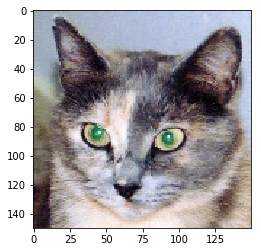

In [0]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
# 入力テンソルと出力テンソルのリストに基づいてモデルをインスタンス化
from keras import models

# 出力側の８層から出力を抽出
layer_outputs = [layer.output for layer in model.layers[:8]]
# 特定の入力のもと、出力を返すモデルを作成
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
# ５つのNumPy配列（層の活性化ごとに一つ）のリストを返す
activations = activation_model.predict(img_tensor)

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


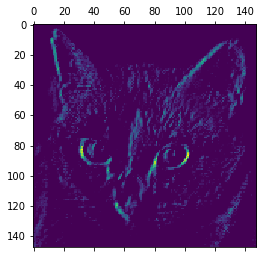

In [0]:
# ３番目のチャネルを可視化
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

対角エッジ検出器

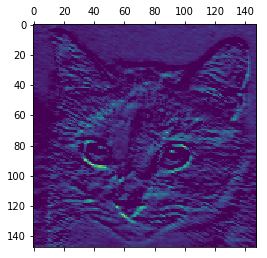

In [0]:
# ３０番目のチャネルを可視化
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

明るい緑のドット検出器

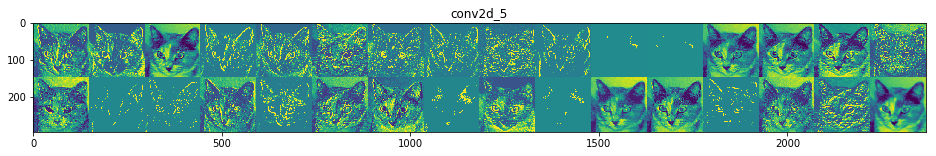

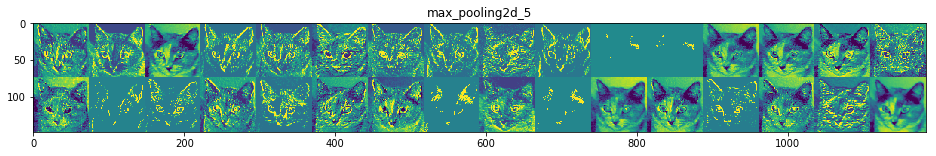

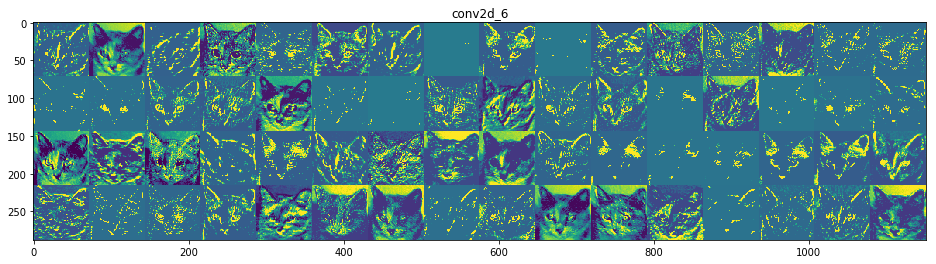

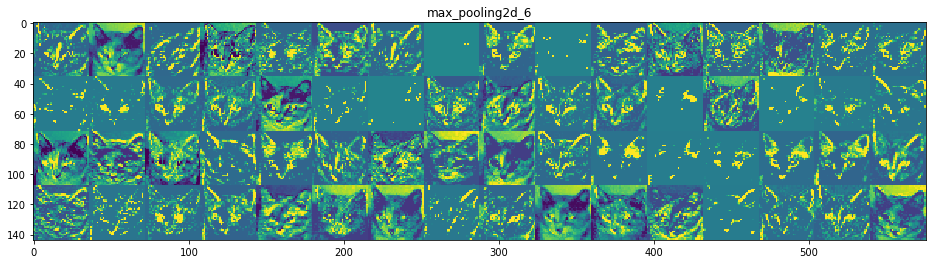

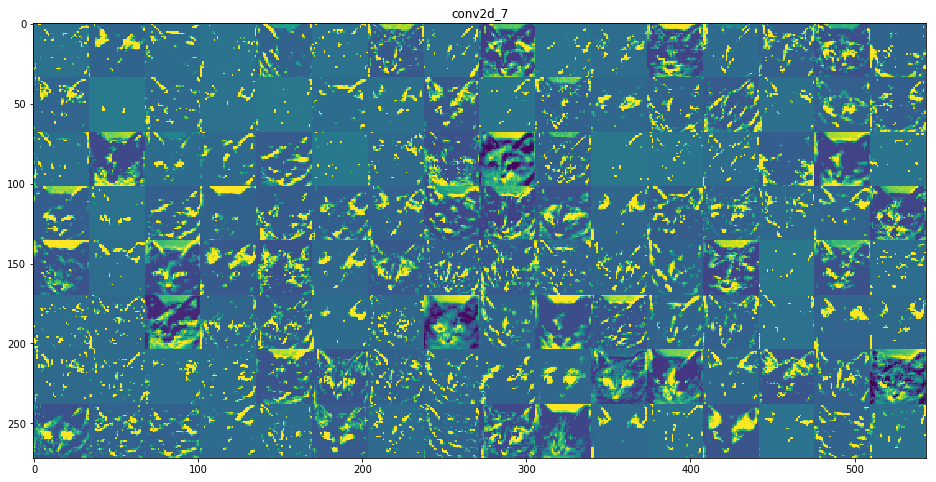

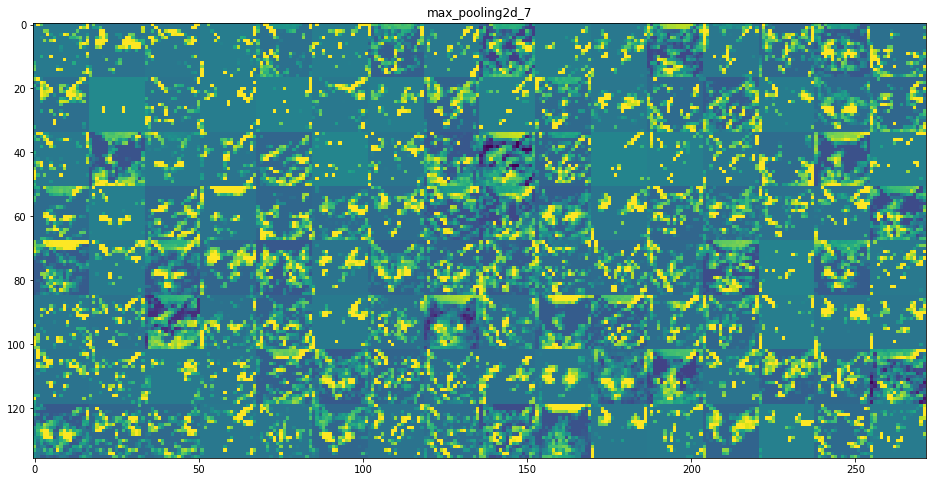

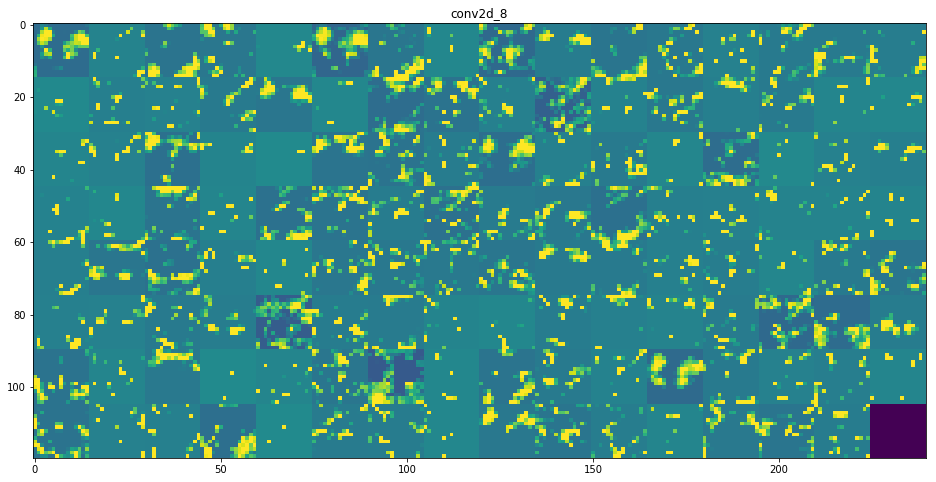

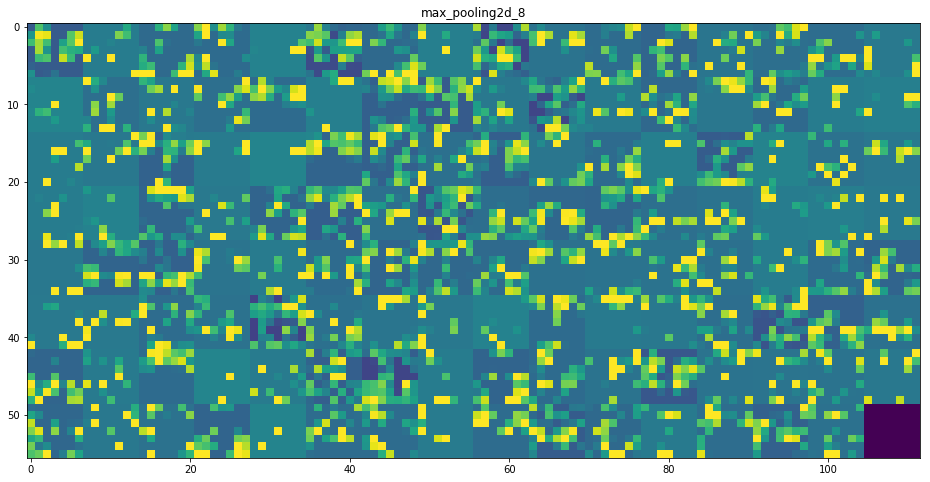

In [0]:
# 中間層の活性化ごとにすべてのチャネルを可視化

# プロットの一部として使用する層の名前
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 特徴マップを表示
for layer_name, layer_activation in zip(layer_names, activations):

    # 特徴マップに含まれる特徴量の数
    n_features = layer_activation.shape[-1]

    # 特徴マップの形状
    size = layer_activation.shape[1]

    # この行列で活性化のチャネルをタイル表示
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 各フィルタを１つ大きな水平グリッドでタイル表示
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 整理
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # グリッドを表示
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

# CNNのフィルタを可視化

In [0]:
# 損失テンソルを定義
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
# 入力に関する損失関数の勾配を取得
grads = K.gradients(loss, model.input)[0]

In [0]:
# 勾配の正則化
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])
# テスト
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
# 確率的勾配降下法を使って損失値を最大化
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 勾配上昇法を40ステップ実行
step = 1.  # 各勾配の更新の大きさ
for i in range(40):
    # 損失値と勾配値を計算
    loss_value, grads_value = iterate([input_img_data])
    # 損失が最大になる方向に入力画像を調整
    input_img_data += grads_value * step

In [0]:
# テンソルを有効な画像に変換
def deprocess_image(x):

    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# フィルタ可視化
def generate_pattern(layer_name, filter_index, size=150):

    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

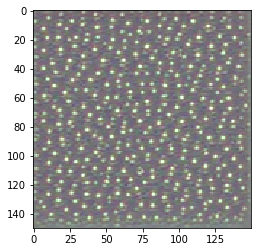

In [0]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


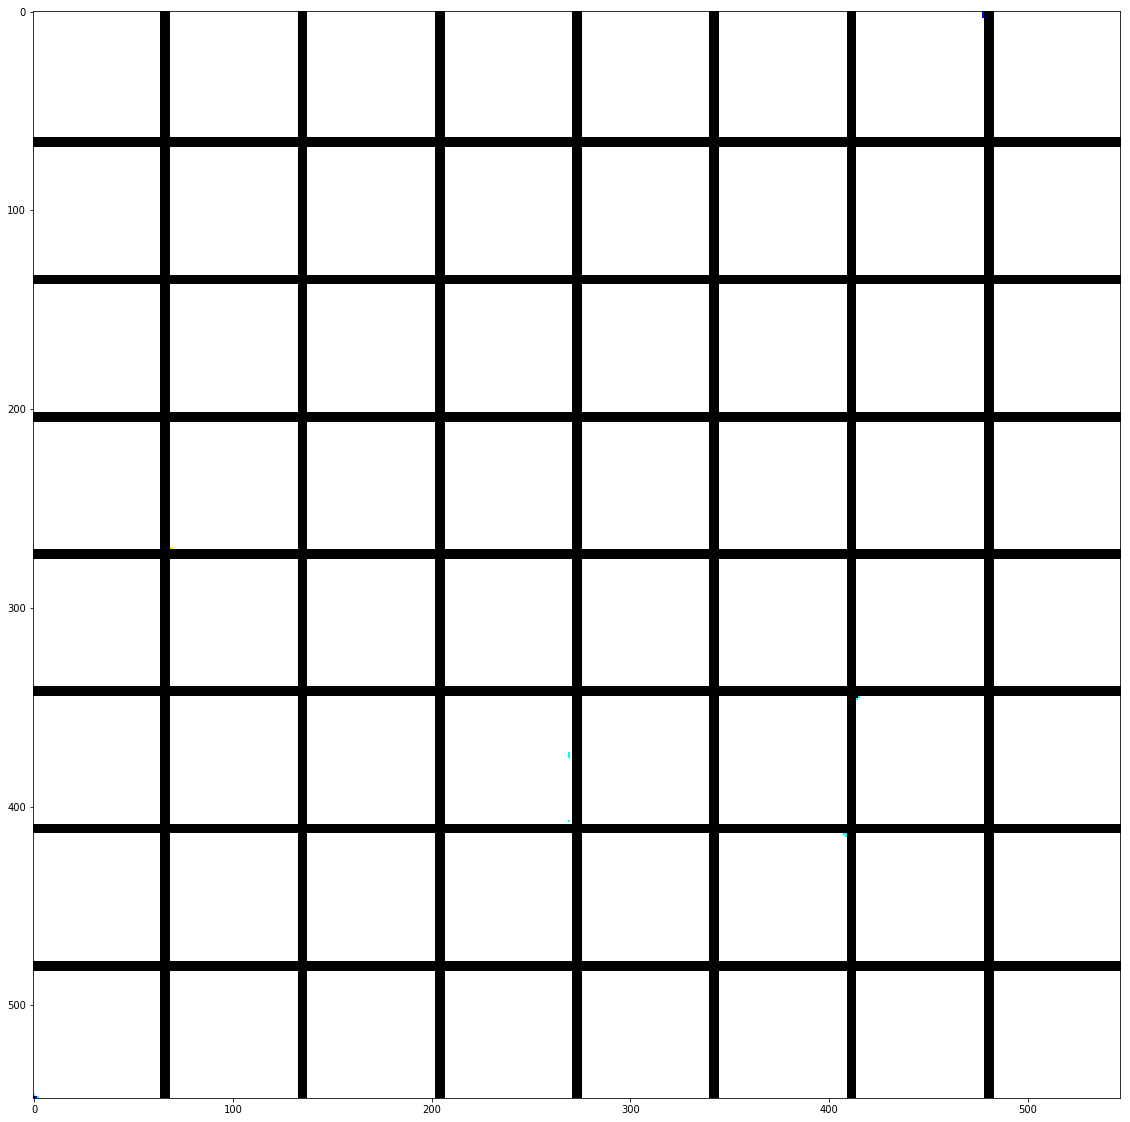

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


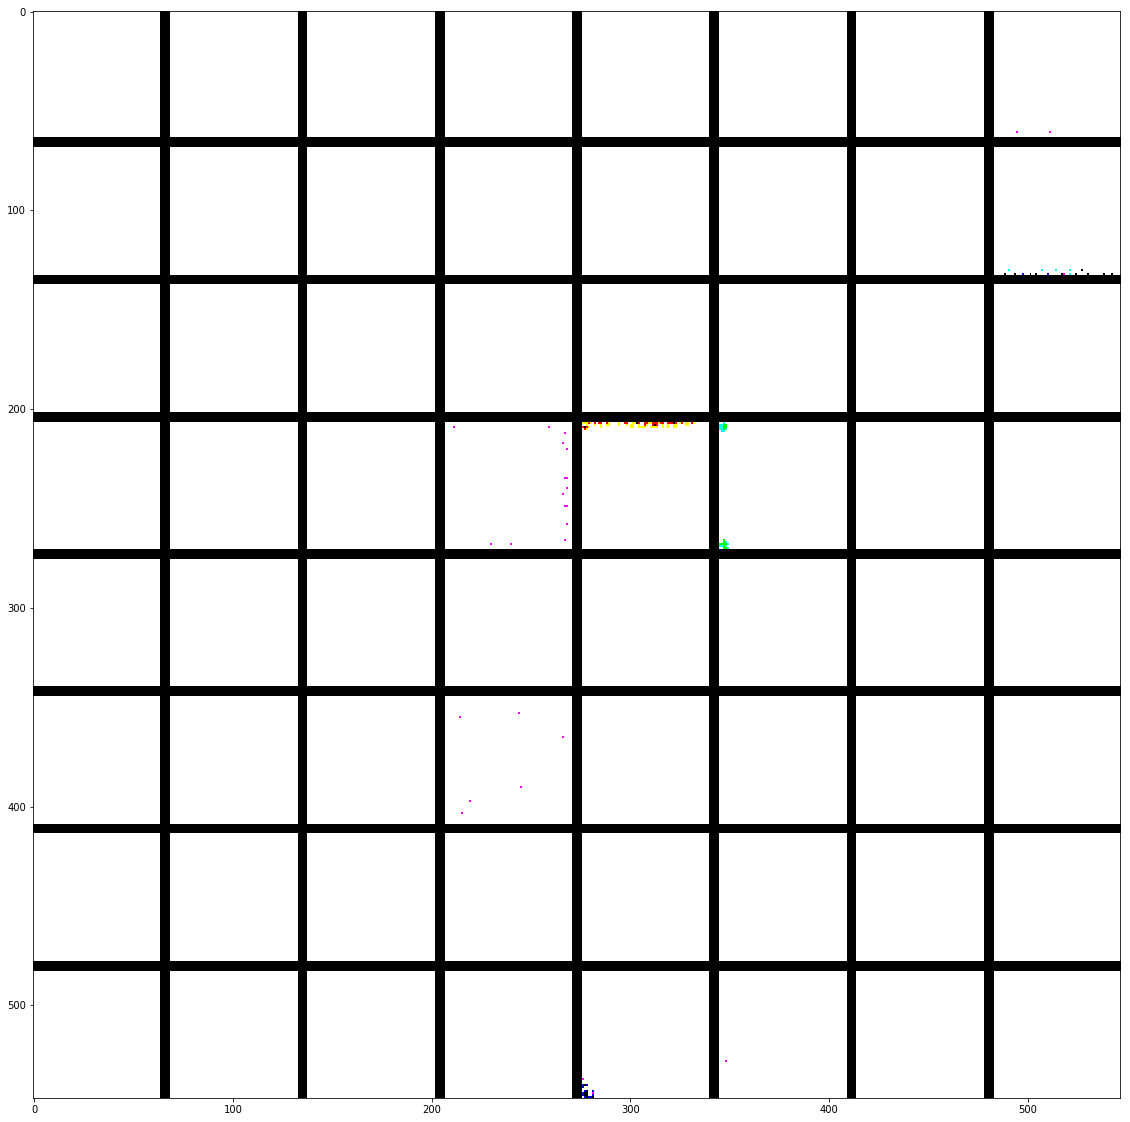

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


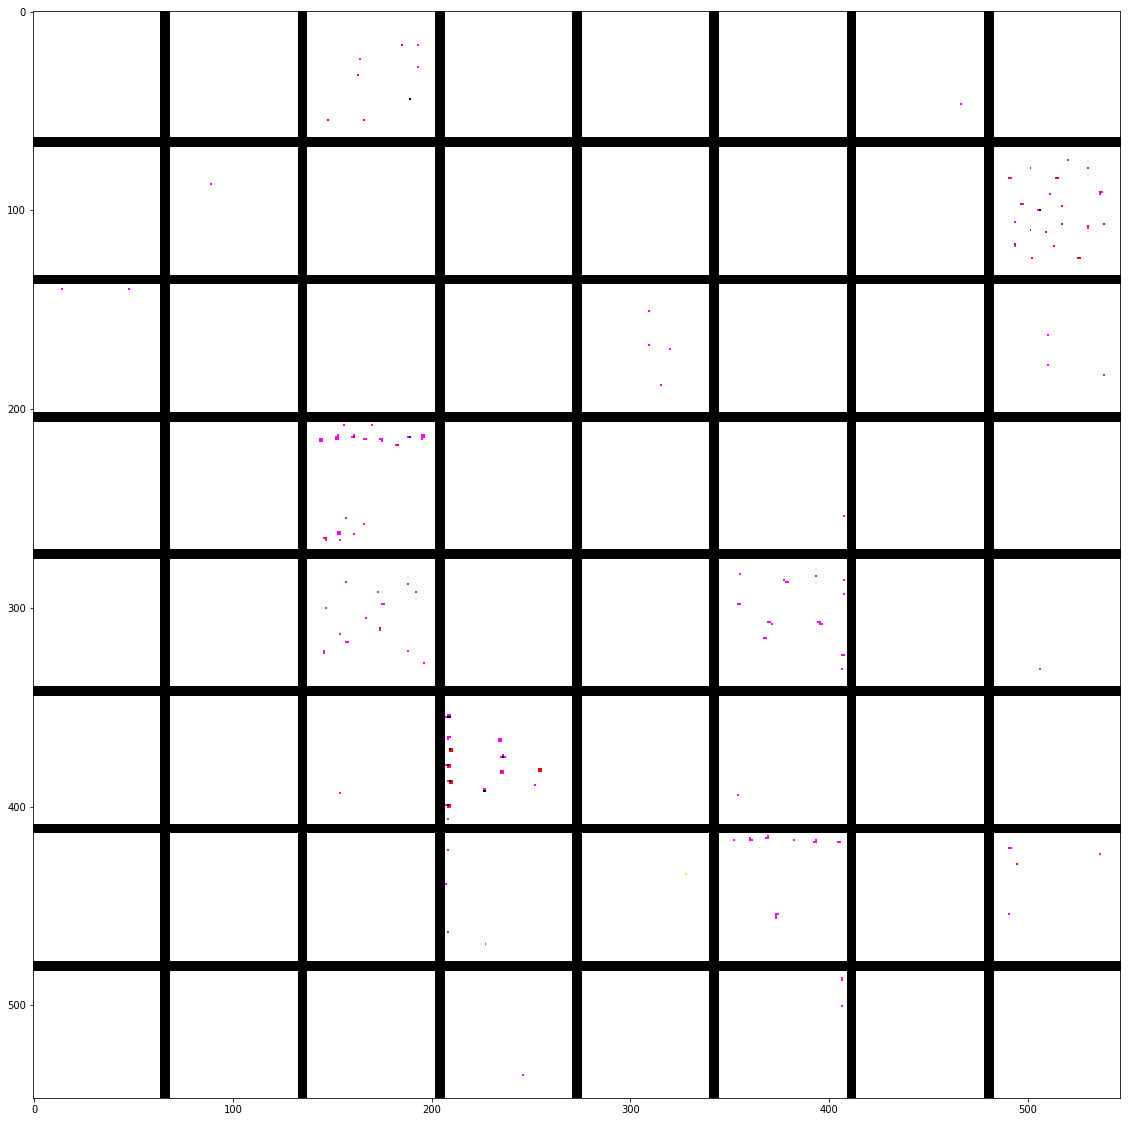

KeyboardInterrupt: 

In [0]:
# 層の各フィルタの応答パターンで構成されたグリッドの生成
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  
        for j in range(8):  

            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

### クラスの活性化をヒートマップとして可視化

In [1]:
# VGG16ネットワークと学習済みの重みを読み込む
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

Using TensorFlow backend.


In [5]:
# ローカルファイルを直接アップロードする
from google.colab import files
uploaded = files.upload()


Saving elephant.jpg to elephant.jpg


In [0]:
# VGG16に合わせて画像を前処理
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [7]:
# 予測
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 1us/step
Predicted: [('n02504458', 'African_elephant', 0.7780131), ('n01871265', 'tusker', 0.19497816), ('n02504013', 'Indian_elephant', 0.024837723)]


In [8]:
np.argmax(preds[0])

386

In [0]:
from keras import backend as K
# gRAD-cam アルゴリズムの設定
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

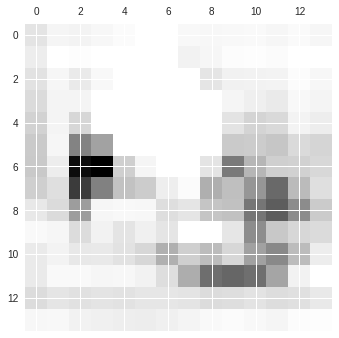

In [12]:
import matplotlib.pyplot as plt
# ヒートマップの後処理
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [17]:
# 元画像にスーパーインボース
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

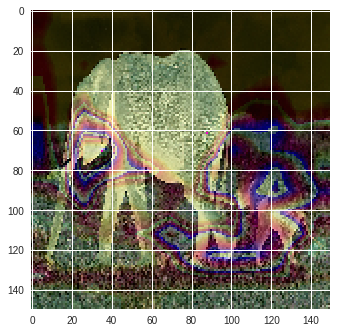

In [19]:
# 単一の画像の前処理
img_path = 'elephant_cam.jpg'

# 4次元テンソルへ
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(img_tensor[0])
plt.show()